https://www.tensorflow.org/guide/migrate/migrating_feature_columns#with_keras_preprocessing_layers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
features = {
    'type': [0, 1, 1],
    'size': ['small', 'small', 'medium'],
    'weight': [2.7, 1.8, 1.6],
}
labels = [1, 1, 0]
predict_features = {'type': [0], 'size': ['foo'], 'weight': [-0.7]}

In [30]:
tf.expand_dims(inputs['weight'], -1)

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_2')>

In [21]:
vocab = ['small', 'medium', 'large']
one_hot_dims = 3
embedding_dims = 4
weight_mean = 2.0
weight_variance = 1.0

# With Keras preprocessing layers

In [20]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/CategoryEncoding
# ont_hot, multi_hot, count
category_layer  = tf.keras.layers.CategoryEncoding(one_hot_dims, output_mode='one_hot')
category_layer([0, 1, 1])

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [27]:
string_lookup_layer = tf.keras.layers.StringLookup(vocabulary=['small', 'medium', 'large'], num_oov_indices=0)
embedding = tf.keras.layers.Embedding(3, 4)
print(string_lookup_layer(['small', 'medium', 'large']))
embedding(string_lookup_layer(['small', 'medium', 'large']))

tf.Tensor([0 1 2], shape=(3,), dtype=int64)


/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 0.04781235,  0.00721288,  0.015381  ,  0.03969194],
       [ 0.02194849, -0.00267816,  0.02655401, -0.04999126],
       [-0.03614867,  0.01086342, -0.02828635,  0.02415982]],
      dtype=float32)>

In [26]:
normalization_layer = tf.keras.layers.Normalization(axis=None, mean=weight_mean, variance=weight_variance)
normalization_layer(2.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Preprocessing Layer

In [28]:
inputs = {
  'type': tf.keras.Input(shape=(), dtype='int64'),
  'size': tf.keras.Input(shape=(), dtype='string'),
  'weight': tf.keras.Input(shape=(), dtype='float32'),
}
# Convert index to one-hot; e.g. [2] -> [0,0,1].
type_output = tf.keras.layers.CategoryEncoding(
      one_hot_dims, output_mode='one_hot')(inputs['type'])
# Convert size strings to indices; e.g. ['small'] -> [1].
size_output = tf.keras.layers.StringLookup(vocabulary=vocab)(inputs['size'])
# Normalize the numeric inputs; e.g. [2.0] -> [0.0].
weight_output = tf.keras.layers.Normalization(
      axis=None, mean=weight_mean, variance=weight_variance)(inputs['weight'])
outputs = {
  'type': type_output,
  'size': size_output,
  'weight': weight_output,
}
preprocessing_model = tf.keras.Model(inputs, outputs)

In [32]:
type(type_output), type_output.shape, type(size_output), size_output.shape, type(weight_output), weight_output.shape

(keras.engine.keras_tensor.KerasTensor,
 TensorShape([None, 3]),
 keras.engine.keras_tensor.KerasTensor,
 TensorShape([None]),
 keras.engine.keras_tensor.KerasTensor,
 TensorShape([None]))

In [29]:
# Apply the preprocessing in tf.data.Dataset.map.
dataset = tf.data.Dataset.from_tensor_slices((features, labels)).batch(1)
dataset = dataset.map(lambda x, y: (preprocessing_model(x), y),
                      num_parallel_calls=tf.data.AUTOTUNE)
# Display a preprocessed input sample.
next(dataset.take(1).as_numpy_iterator())

({'type': array([[1., 0., 0.]], dtype=float32),
  'size': array([1]),
  'weight': array([0.70000005], dtype=float32)},
 array([1], dtype=int32))

# Model with Embedding

In [14]:
inputs = {
  'type': tf.keras.Input(shape=(one_hot_dims,), dtype='float32'),
  'size': tf.keras.Input(shape=(), dtype='int64'),
  'weight': tf.keras.Input(shape=(), dtype='float32'),
}
# Since the embedding is trainable, it needs to be part of the training model.
embedding = tf.keras.layers.Embedding(len(vocab), embedding_dims)
outputs = tf.keras.layers.Concatenate()([
  inputs['type'],
  embedding(inputs['size']),
  tf.expand_dims(inputs['weight'], -1),
])
outputs = tf.keras.layers.Dense(1)(outputs)
training_model = tf.keras.Model(inputs, outputs)
training_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 4)            12          ['input_8[0][0]']                
                                                                                            

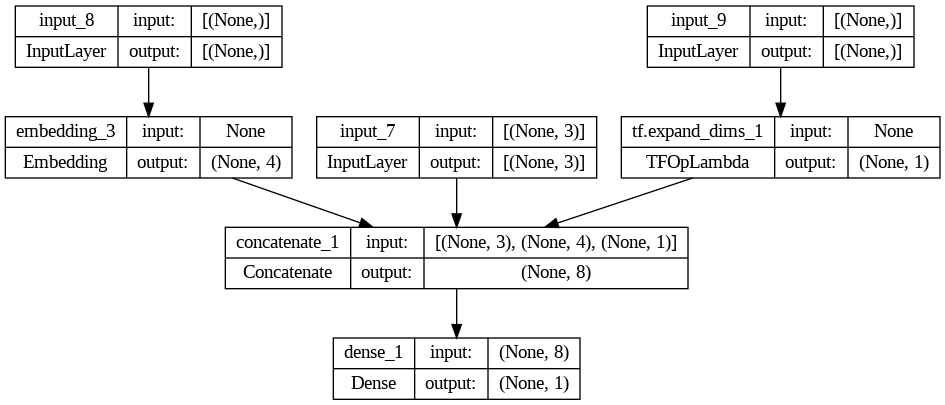

In [17]:
tf.keras.utils.plot_model(training_model, show_shapes=True)

In [12]:
# Train on the preprocessed data.
training_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))
training_model.fit(dataset)

3/3 [==============================] - 1s 6ms/step - loss: 0.8682


In [13]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs, outputs)

predict_dataset = tf.data.Dataset.from_tensor_slices(predict_features).batch(1)
inference_model.predict(predict_dataset)

1/1 [==============================] - 0s 323ms/step


array([[0.04426679]], dtype=float32)